# Euclidean Traveling Salesman Problem

We need to construct an approximate algorithm for solving the euclidean TSP - finding a Hamiltonian cycle of minimum weight, if our graph vertices are points from $ \mathbb {R} ^ d $, all points are connected by edges, where the edge weight is the usual metric between points in this space. We will solve the problem on the plane $ \mathbb{R} ^ 2 $.

In [1]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

** Theorem (Arora 1996) ** - states that $ \forall \epsilon> 0$ $\exists$ is a polynomial algorithm that solves our problem with accuracy $ (1 + \epsilon) $, namely, it searches for a Hamiltonian cycle, weight which has the above accuracy in comparison with the optimal one. The algorithm in the theorem is proposed with the asymptotics $ O (n^{O (\frac {1}{\epsilon})}) $ (in the original version).

We will describe this algorithm briefly. First, we take a random square $ B $ with dimensions depending on $ \ epsilon $ (the sides are taken from a uniform distribution), which covers all points of the graph. Then we build a grid so that each cell can have at most one point, and we place all the points of the graph on the edges of the corresponding cells. Then we form a tree of quadrants (the leaves of the tree are previously constructed cells), and on the edges of all squares (nodes of the tree) we build a certain number of so-called "portals". These are the points that limit the possible paths so that any path when passing through the border of the square can only pass through the portal, and each portal is used no more than 2 times. And then, in a certain way, using dynamic programming, we fill in the table, which is built for all the squares from the tree (starting with the leaves) and for each square for all the "correct" solutions inside it and the "correct" passages through the portals.

The indicated asymptotics is achieved due to the fact that the size of the largest square is correctly selected, and the logarithmic number of portals (but depending on $ \epsilon $) is selected for each square. And the table for dynamics as a result turns out to be of size $ O (n^\frac{1}{\epsilon}) * O (n^4) $, that is, the time of its calculation satisfies the asymptotics.

This alogrhythm has a rather non-trivial implementation (especially for the step related to dynamics), and is of more theoretical interest than practical.

Therefore, it is proposed to solve the problem **with a genetic alogrhythm**.

When solving problems using a genetic alogrhythm, methods are used that are similar to those found in natural selection:
* selection: we select from the population the proportion of those who "go further".
* inheritance: the transfer of some properties, characteristics, information to the next generation.
* crossbreeding: creating a new generation.
* mutation: a certain number of individuals is selected from the entire population (individual = trial solution), the characteristics of which change in accordance with certain operations - they mutate

At the end of the alogrhythm, the "strongest" specimen returns from the point of view of the given properties.

In relation to our problem, we will represent the individuals of the population as an array of indices of length n (the number of vertices in the graph) corresponding to the numbers of the vertices in our graph on the plane. That is, it will be a representation of the Hamiltonian cycle in the graph, where the vertex is connected to the trace. in the array as a vertex (the last in the array is connected to the first).

The choice of the initial population will be a simple mixing of the indices. The population size is initially set.
The selection will be made by choosing those arrays that correspond to the cycles with the least weight.
We will stop our algorithm after passing the initially specified number of iterations.
Next, we will set the crossing functions and mutation functions.

Mutation functions: take as input the population, and the estimated number of mutations. Returns the mutated elements of the population.

We considered 2 types of mutations:
* **Swap Mutation** - here at the representative of the population 2 random elements in the array are swapped.
* **Inversion Mutation** - here a random substring is selected from the representative of the mutation, inverted and put in the same place in the array.

In [2]:
def swapMutate(population,  n):
    """
    function of calculating mutations in a population:
    changes two random elements for some
    representatives of the population
    population - accordingly the population
    n - the number of mutations in the population
    """
    
    indices = sps.randint(0, population.shape[0]).rvs(size=n)
    mutations = np.copy(population[indices])
    for i in range(n):
        index1, index2 = sps.randint(0,population.shape[1]).rvs(2)
        mutations[i, index1], mutations[i, index2] = \
        mutations[i, index2], mutations[i, index1]
    return mutations   


def invMutate(population, n):
    """
    Inversion Mutation
    """
    indices = sps.randint(0, population.shape[0]).rvs(size=n)
    mutations = np.copy(population[indices])
    for i in range(n):
        index1, index2 = sps.randint(1,population.shape[1]).rvs(2)
        mutations[i, index1: index2+1] = mutations[i, index2: index1-1:-1]
    return mutations    

Crossing functions: take two parents as input (2 arrays) and return a child (also an array).
    
I used the following crossing options:
* **Partitially-Mapped Crossover** - selects a random substring from the 1st parent and inserts it in the same place in the child, and the rest is filled in by the 2nd parent, in the same order as the array elements in parent 2 are contained.

* **Cycle Crossover** - based on cycles: for example, the 0th element is inserted by the 1st parent, looks at the index of this element from the 2nd parent - it is easy to understand that an element from the 1st parent will be exactly inserted at this index (otherwise there will be two identical elements in the child) - we insert the email of the 1st parent at this index. We continue this way until we close ourselves - that is, we do not come to the element that we have already filled. Then, either we have already filled everything in - we end the procedure, or not - in this case, the 2nd parent does the same, starting from the index of the first unfilled element in the child. So the parents change their "roles" until they fill everything.

In [7]:
def PMX(specimen1, specimen2):
    """
    Partitially-Mapped Crossover
    """
    index1, index2 = np.sort(sps.randint(0, len(specimen1)).rvs(size=2))
    offspring = np.ones(len(specimen1))*-1
    offspring[index1 : index2 + 1] = specimen1[index1 : index2 + 1]
    k = 0 
    for el in specimen2:
        if (k == index1):
            k = index2 + 1
        if (el not in specimen1[index1 : index2 + 1]):
            offspring[k] = el
            k += 1
    return offspring


def CX(specimen1, specimen2):
    """
    Cycle Crossover
    """
    argparent1 = np.argsort(specimen1)
    argparent2 = np.argsort(specimen2) #индексы отсорт. массива 2
    
    offspring = np.ones(len(specimen1))*-1
    offspring = offspring.astype(int)
    offspring[0] = specimen1[0]
    ind = 0
    curr_argp = argparent2
    curr_spec = specimen1
    for i in range(len(offspring)-1):
        ind = curr_argp[offspring[ind]]
        if (offspring[ind] != -1):
            ind  = np.argmin(offspring)
            if (np.all(curr_spec ==specimen1)):
                curr_argp = argparent1
                curr_spec = specimen2
            else:
                curr_argp = argparent2
                curr_spec = specimen1
        offspring[ind] = curr_spec[ind]        
    return offspring


#само скрещивание популяции   
def getCrossover(population, func):
    """
    population crossing - generation change
    population - population
    func - cross function
    """
    generation = list()
    for i in range(population.shape[0]):
        for j in range(i, population.shape[0]):
            offspring = func(population[i], population[j])
            generation.append(offspring)
    return np.array(generation)

In [8]:
def createPopulation(Graph, n):
    """
    population creation by
    random mixing
    n - population size
    """
    specimen = np.arange(Graph.shape[0]) 
    population = list()
    for i in range(n):
        arr = np.copy(specimen)
        np.random.shuffle(arr)
        population.append(arr)
    return np.array(population)

# path length for some representative of the population
def pathLength(Graph, specimen):
    """
    counts the length of the cycle corresponding
    an array of indexes specimen
    the last, closing edge of the cycle -
    is counted between the last and 1st e-s of the array

    specimen - array of vertex indices of the graph - individual of the population
    """
    length = 0
    for i in range(Graph.shape[0]):
        length += np.linalg.norm(Graph[int(specimen[i])] - \
            Graph[int(specimen[(i + 1) % Graph.shape[0]])])
    return length


def sortPopulation(Graph, population):
    """
    selection function - sorting the population by cycle length
    """
    return np.array(sorted(population, 
                    key= lambda x:pathLength(Graph, x)))
    

# the genetic algorithm itself
def Genetic(Graph, iter_count, popul_count, mutate_count=-1,
           mutate_func=swapMutate, cross_func=PMX):
    """
    Genetic alogrhythm
    Graph - a graph in the form of an array of points on a plane
    iter_count - number of iterations
    popul_count - population size
    mutate_count - the number of mutations
    mutate_func - mutation function
    cross_func - cross function
    displays an array of indices - the "best" individual in the population
    """
    population = createPopulation(Graph, popul_count)
    
    if (mutate_count == -1):
        mutate_count = int(popul_count / 4)
    
    for i in tqdm(range(iter_count)):
        mutations = mutate_func(population, mutate_count)
        offsprings = getCrossover(population, cross_func)

        population = np.vstack((population, mutations,
                                offsprings))
        population = sortPopulation(Graph, population)[:popul_count]

    return population[0]       

So, to begin with, let's examine the dependence of the accuracy of the answer and the operating time on the size of the population (we will fix the mutation function and the crossing function for now).
Let's test it for an arbitrary graph of size 40.

In [9]:
def getRandomGraph(N):
    """
    generates an arbitrary graph of size N
    each coordinate is generated from a uniform
    distribution on the segment [0, N]
    """
    Graph = list()

    for i in range(N):
        Graph.append([sps.uniform(0, N).rvs(),
                    sps.uniform(0, N).rvs()])
    return np.array(Graph)


def getCycleIndices(indices):
    """
    returns a "looped" array of indices -
    for the convenience of displaying on the chart
    """
    new_indices = np.ones(len(indices) + 1)
    new_indices[:len(indices)] = indices
    new_indices[-1] = indices[0]
    return new_indices.astype(int)

100%|██████████| 100/100 [02:59<00:00,  1.80s/it]


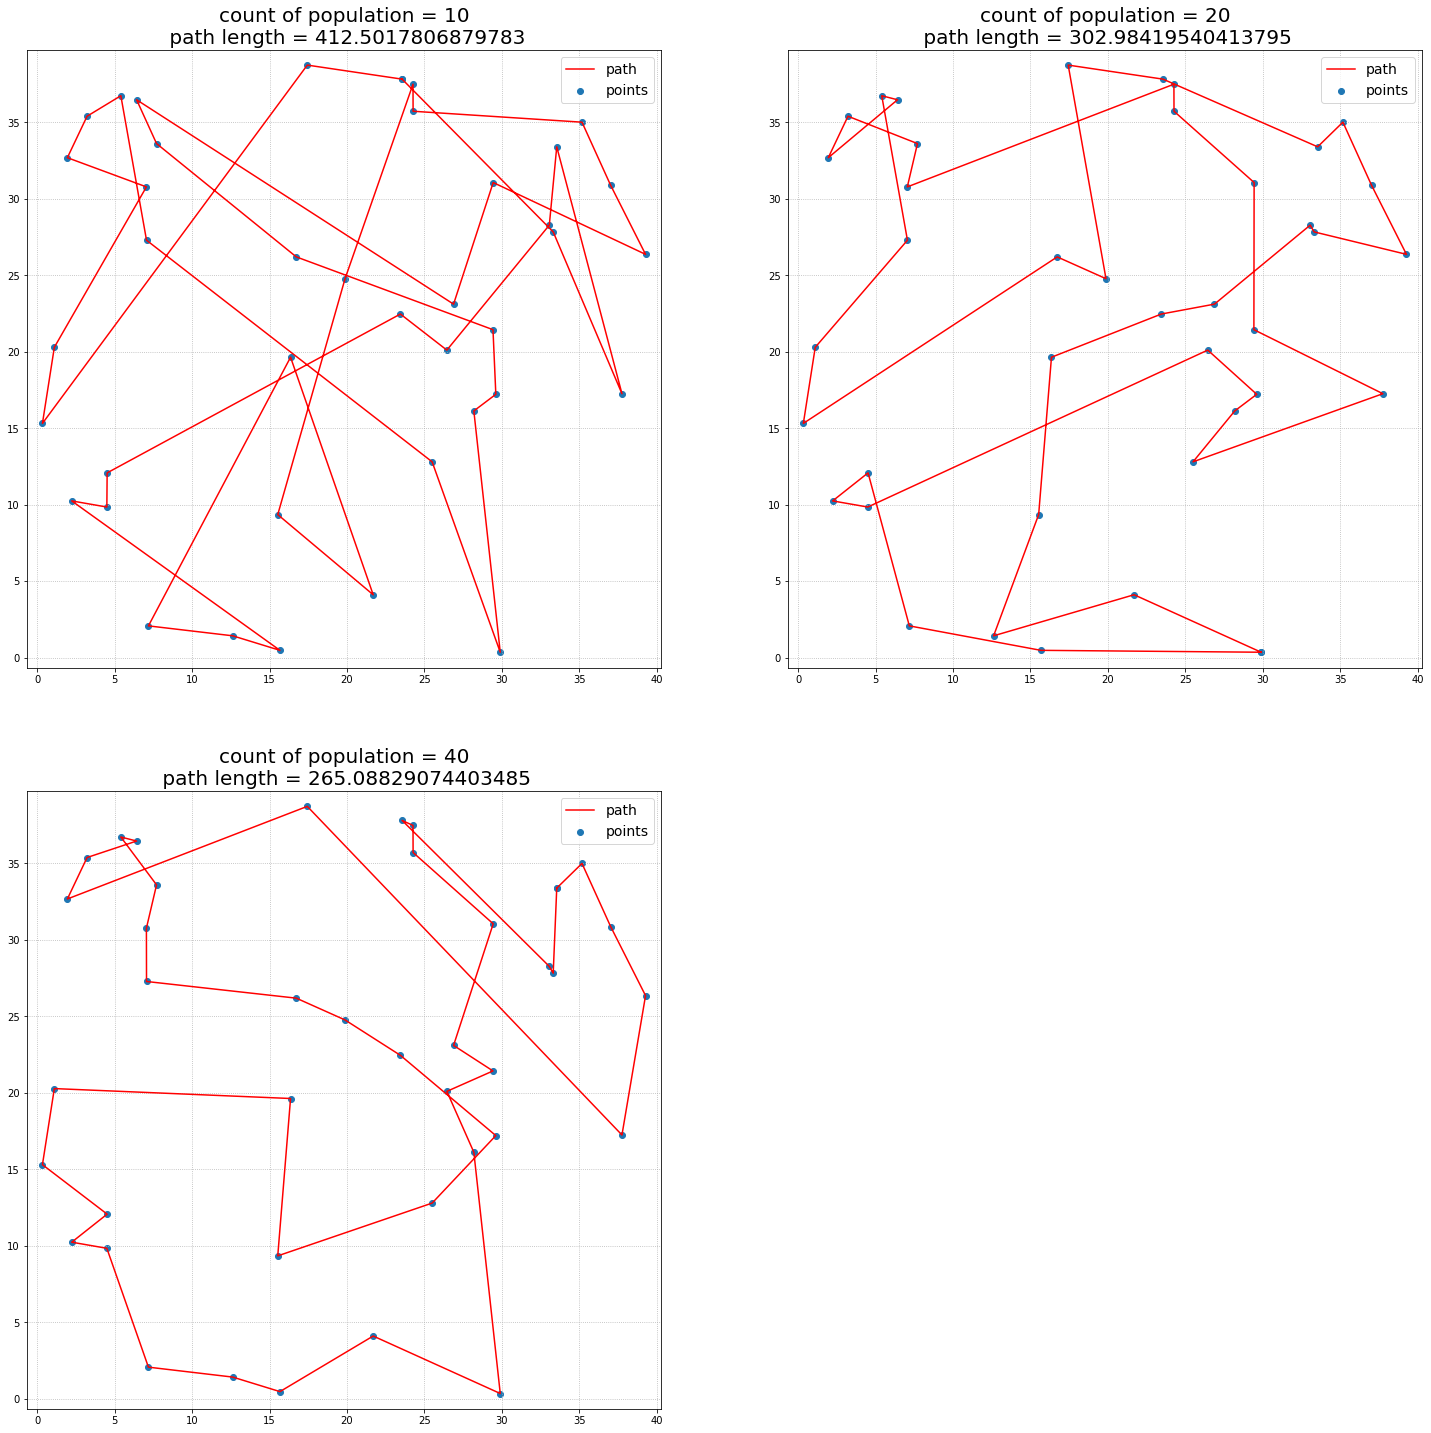

In [10]:
iter_count = 100 #number of iteration
popul_count = [10, 20, 40] #population size


Graph = getRandomGraph(40) #random graph of the size 40

plt.figure(figsize=(25,25))

for i, p in enumerate(popul_count):
    indices = getCycleIndices(Genetic(Graph, iter_count, p))
    
    x = Graph[indices, 0]
    y = Graph[indices, 1]
    
    plt.subplot(2, 2, i+1)
    
    plt.title('count of population = {}\n path length = {}'\
              .format(p, pathLength(Graph, indices)), fontsize=20)
    plt.xlim((np.min(x)-1, np.max(x)+1))
    plt.ylim((np.min(y)-1, np.max(y)+1))
    
    plt.plot(x, y, color="r",label="path")
    plt.scatter(x,y, label="points")

    plt.grid(ls=":")
    plt.legend(fontsize=14)

plt.show()

As we can see, for a fixed number of iterations of the method, the more elements in the population, the better the result - as the size increases, we get closer and closer to the optimal solution - the Hamiltonian cycle of the lowest weight. But at the same time the execution time grows.

Now let's try to observe what results different methods of mutations and methods of crossing will give us (with a fixed population size and number of iterations).

For this we will take real data - namely, a graph describing 128 cities in North America.

In [11]:
cities = np.genfromtxt("NorthAmerica_xy.txt")
print(cities.shape)

(128, 2)


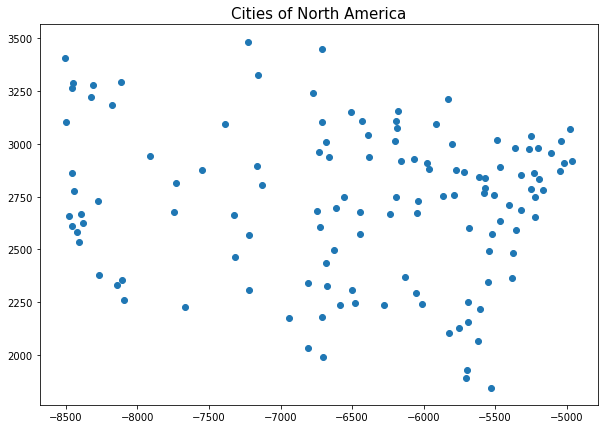

In [12]:
plt.figure(figsize=(10, 7))
plt.title("Cities of North America", fontsize=15)
plt.scatter(cities[:, 0],cities[:, 1], label="points")
plt.show()

100%|██████████| 400/400 [12:34<00:00,  1.89s/it]


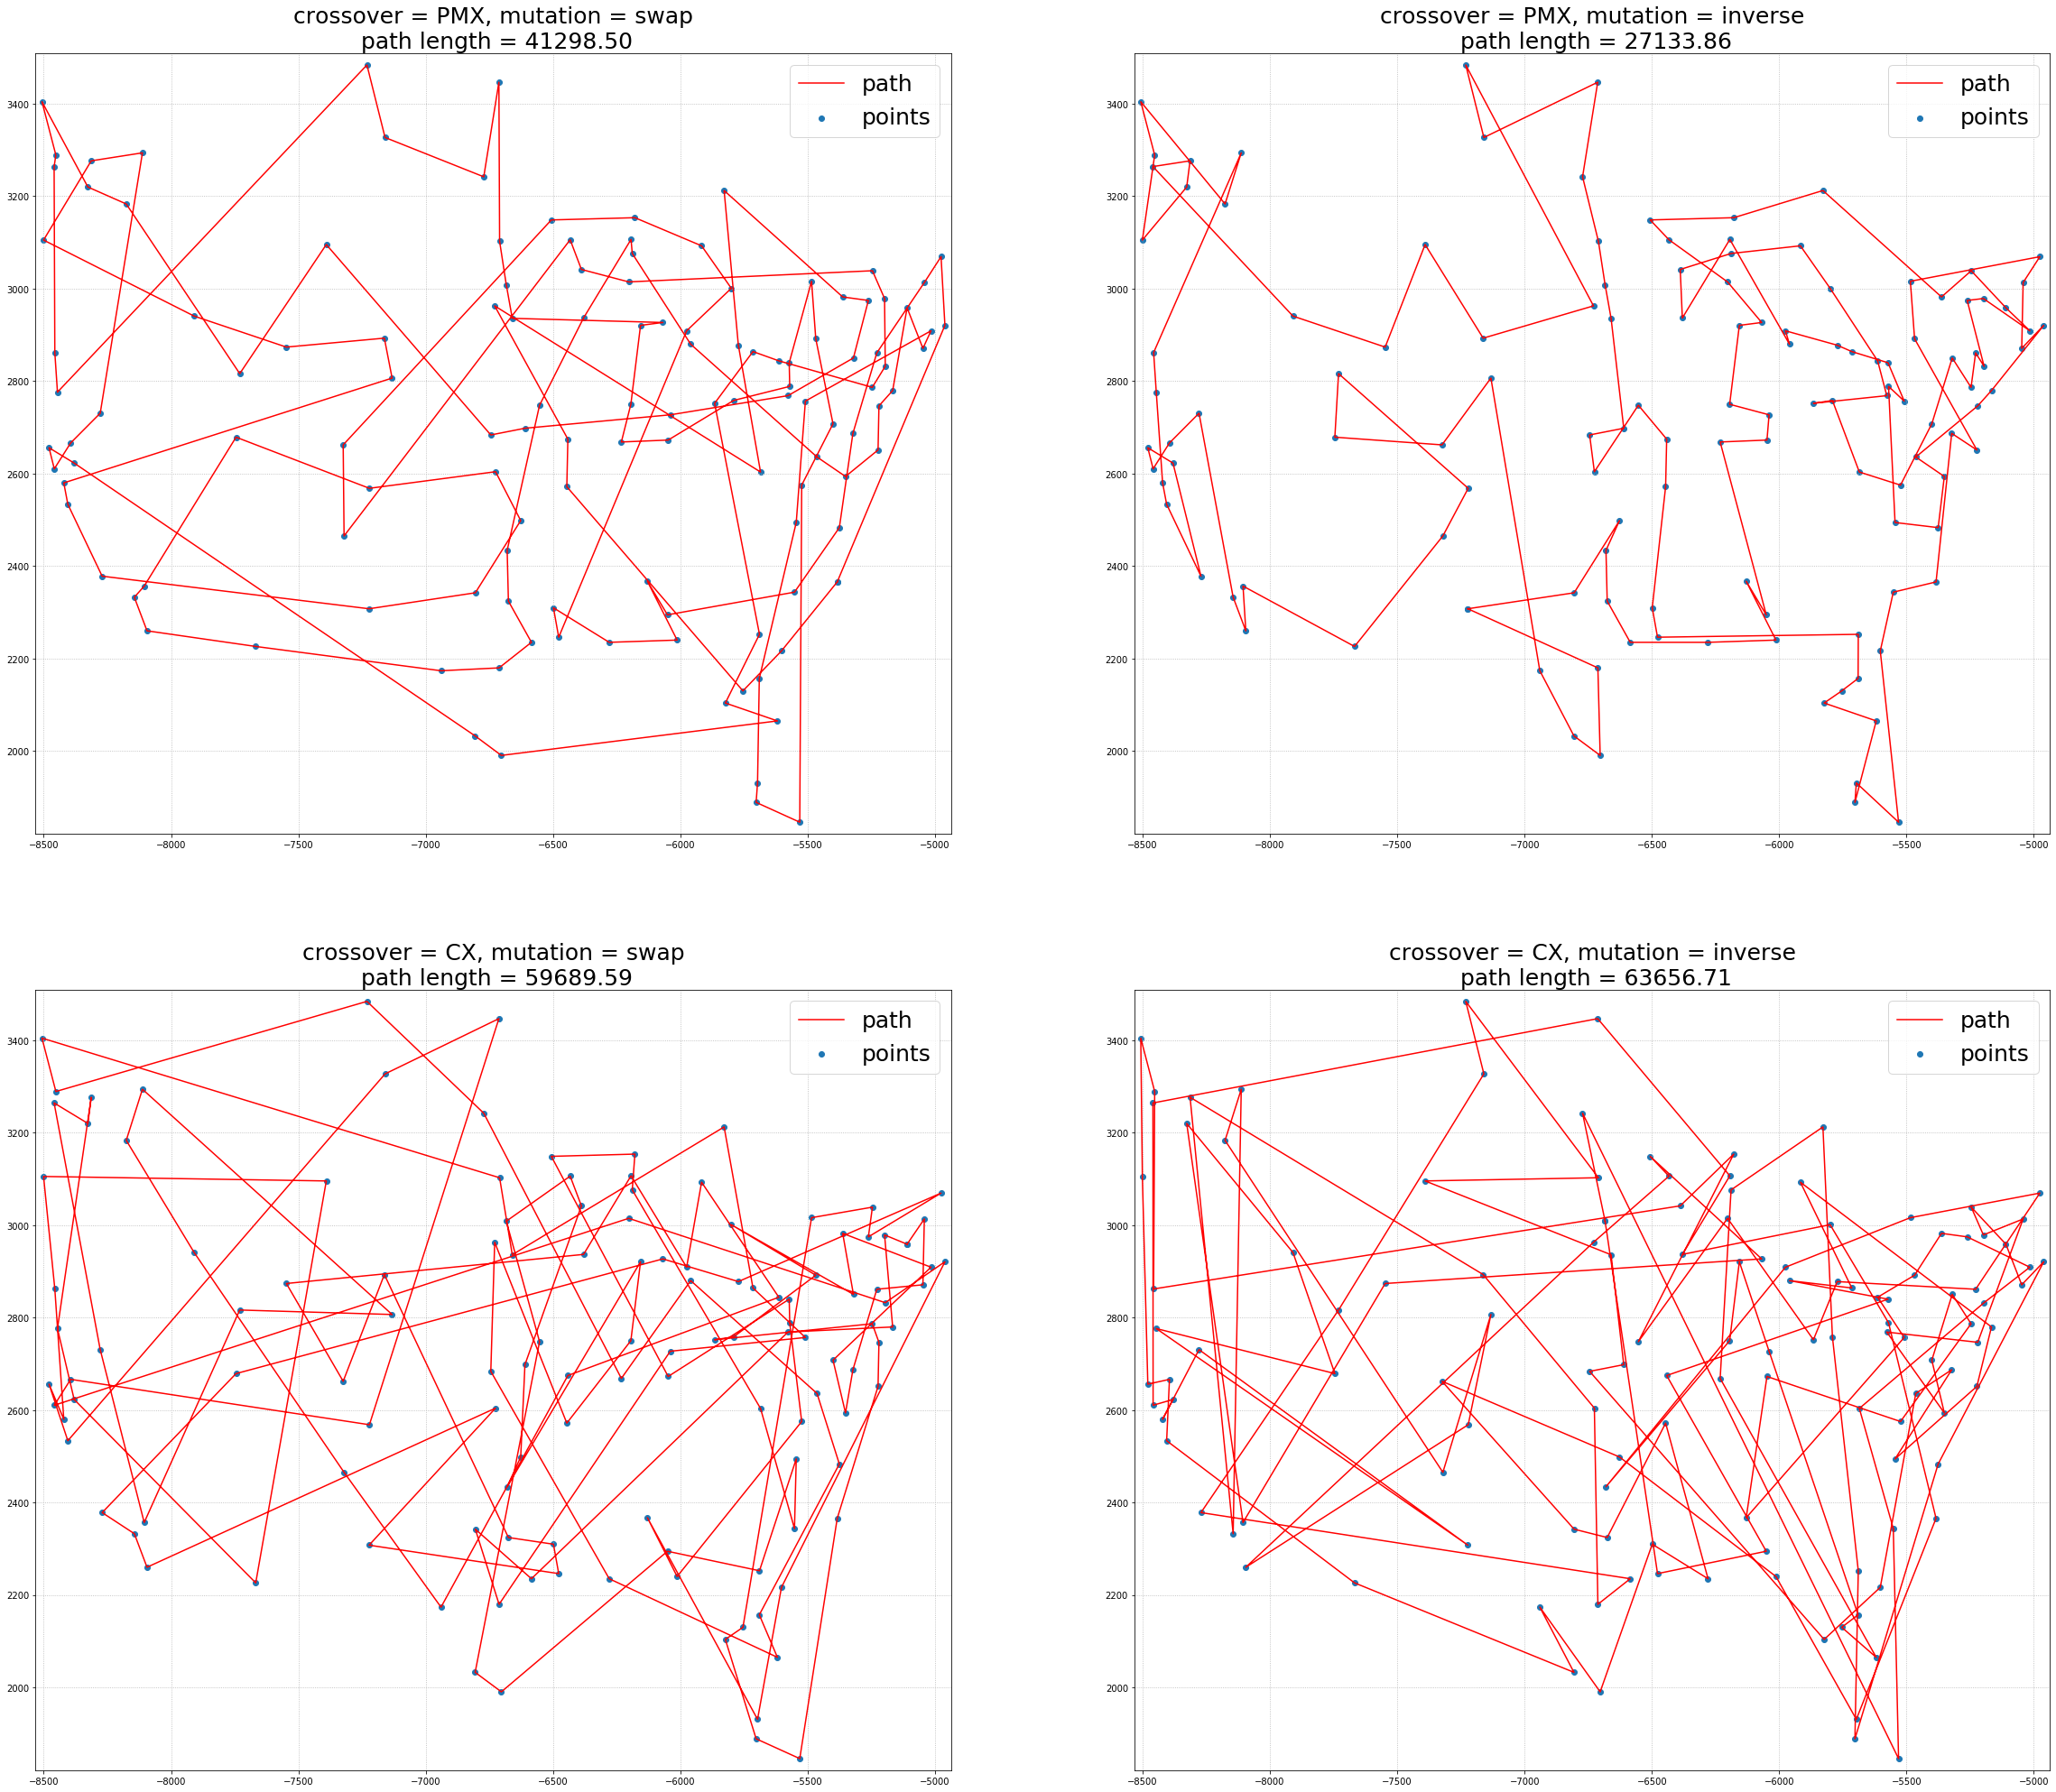

In [14]:
iter_count = 400
popul_count = 35

mutations = [swapMutate, invMutate]
cross = [PMX, CX]
M, C = np.meshgrid(mutations, cross)
M = np.ravel(M)
C = np.ravel(C)

mut_titles = ["swap", "inverse"]
cros_titles = ["PMX","CX"]
MT, CT = np.meshgrid(mut_titles, cros_titles)
MT = np.ravel(MT)
CT = np.ravel(CT)


plt.figure(figsize=(40, 35))

for i, (m, c, mt, ct) in enumerate(zip(M, C, MT, CT)):
    indices = getCycleIndices(Genetic(cities, iter_count, 
                                            popul_count,
                                       mutate_func=m,
                                       cross_func=c))
    
    x = cities[indices, 0]
    y = cities[indices, 1]
    
    plt.subplot(2, 2, i+1)
    plt.title("crossover = %s, mutation = %s\n path length = %.2f" \
          % (ct, mt, pathLength(cities, indices)), fontsize=25)
    plt.xlim((np.min(x)-25, np.max(x)+25))
    plt.ylim((np.min(y)-25, np.max(y)+25))
    plt.plot(x, y, color="r",label="path")
    plt.scatter(x,y, label="points")

    plt.grid(ls=":")
    plt.legend(fontsize=25)
    
plt.show()    

As we can see, the results show significant differences.

The algorithm using the Inversion Mutation function and the Partitially-Mapped Crossover function gives the best results - path length $ \approx 29679 $. In second place is the implementation with the Swap Mutation and the same crossing - the path $ \approx 38508 $, that is, it is worse by about 30%.

Algorithms that use Cycle Crossover as the crossing function worked much worse. For both adaptations, regardless of the mutation (the difference between them turned out to be insignificant), the solution turned out to be almost two times worse than for allogrhythms using PMX.

Apparently, for such data, you should not take the CX function as a cross. Although it is quite possible that on some other graphs the situation will be different.

But it's worth noting that algorithms using CX were faster than those using PMX as a cross.
***
We believe that one cannot be completely sure of the effectiveness of certain mutation and crossing methods for solving the problem in the general case. It is necessary to try different functions of crossing and mutation on different data, various parameters of the algorithm and see which of these works more efficiently for these specific data, find a compromise between the optimal solution and the operating time.